# Model selection

Cross-validation is used here to select the best model. In this script it is used to test the best machine learning model for use in this context.

<u>Tests using the following models :</u>
* Linear regression
* Random forest regressor
* XGBoost
* Extra Trees Regressor

<u> The following variables are included in the model:</u>
* Weather variables (rain, temperature, windspeed)
* Time variables (Day of week, month, year, time of day, public holiday)
* Sensor environment variables (within a 500m buffer of the sensor):
    * Betweenness of the street 
    * Buildings in proximity to the sensor
    * Landmarks in proximity to the sensor  
    * Furniture in proximity to the sensor    
    * Lights in proximity to the sensor   

In [70]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor 
import xgboost as xgb
from sklearn.pipeline import Pipeline
import folium
import branca.colormap as cm
from eli5.sklearn import PermutationImportance
import joblib
import os
import psutil
import geopy.distance
from sklearn.model_selection import TimeSeriesSplit

from Functions import *

#https://goldinlocks.github.io/Time-Series-Cross-Validation/ 
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        # Define number of samples
        n_samples = len(X)
        # Define how many samples will be in each of the folds (number of samples divided by number of splits)
        k_fold_size = n_samples // self.n_splits
        # Get an indice for every value in the dataset
        indices = np.arange(n_samples)
                
        margin = 0
        # For each of the folds
        for i in range(self.n_splits):
            # Find the start, and end (and middle?) index of the fold
            start = i * k_fold_size
            stop = start + k_fold_size
            # This is where the training data stops and testing starts
            mid = int(0.9 * (stop - start)) + start
            
            training_indices = indices[start: mid]
            test_indices = indices[mid + margin: stop]
            
            yield training_indices, test_indices
            
# class BlockingTimeSeriesSplit():
#     def __init__(self, n_splits):
#         self.n_splits = n_splits
    
#     def get_n_splits(self, X, y, groups):
#         return self.n_splits
    
#     def split(self, X, y=None, groups=None):
#         # Define number of samples
#         n_samples = len(X)
#         # Define how many samples will be in each of the folds (number of samples divided by number of splits)
#         k_fold_size = n_samples // self.n_splits
#         # Get an indice for every value in the dataset
#         indices = np.arange(n_samples)
                
#         margin = 0
#         # For each of the folds
#         for i in range(self.n_splits):
#             # Find the start, and end (and middle?) index of the fold
#             start = i * k_fold_size
#             stop = start + k_fold_size
#             # This is where the training data stops and testing starts
#             mid = int(0.9 * (stop - start)) + start
#             yield indices[start: mid], indices[mid + margin: stop]            

### Get cluster numbers

In [31]:
cluster_numbers = pd.read_csv("../Data/FootfallData/melbourne_locations.csv")[['sensor_id','Cluster_num_5clusters']]

### Get data

In [4]:
buffer_size_m = 500
input_csv ="../Cleaned_data/FormattedDataForModelling/formatted_data_for_modelling_allsensors_{}.csv".format(buffer_size_m)
Xfull, Yfull, data_time_columns = prepare_x_y_data(input_csv)

In [27]:
Xfull['sensor_id'] = pd.read_csv(input_csv)['sensor_id']

In [33]:
Xfull = pd.merge(Xfull, cluster_numbers, on='sensor_id', how='left')

### Join the cluster number data

In [24]:
# Predictor variables
X=Xfull
# Define number of samples in dataset
n_samples = len(X)
# Get an indice for every value in the dataset
indices = np.arange(n_samples)
# Number of temporal splits
n_temporal_splits= 10
# Define how many samples will be in each of the temporal folds (number of samples divided by number of splits)
k_fold_size = n_samples // n_temporal_splits
# Number of spatial clusters
n_spatial_clusters= 5

In [ ]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        # Define number of samples
        n_samples = len(X)
        # Define how many samples will be in each of the folds (number of samples divided by number of splits)
        k_fold_size = n_samples // self.n_splits
        # Get an indice for every value in the dataset
        indices = np.arange(n_samples)
                
        # I think the margin is about leaving a space between folds
        margin = 0

        ###############################################################
        ###############################################################
        # For each of the temporal folds
        ###############################################################
        ###############################################################
        for temporal_i in range(n_temporal_splits):
            print(f"Temporal split number {temporal_i}")

            # Find the start, and end index of the temporal split
            start = temporal_i * k_fold_size
            stop = start + k_fold_size

            # Find the mid point of this split (where the testing data stops and training starts)
            mid = int(0.9 * (stop - start)) + start
            # Get the indices equating to the rows which will be in the training and testing portions for this temporal split
            training_indices = indices[start: mid]
            test_indices = indices[mid + margin: stop]

            ###############################################################
            ###############################################################
            # Create 3 sets of training and testing indices
            ###############################################################
            ###############################################################
            # For each of the spatial clusters
            for spatial_i in range(len(list(range(0,n_spatial_clusters)))):
                print(f"spatial cluster number {spatial_i}")

                # For this spatial iteration, create lists to store the training and testing indices 
                this_cluster_trainingindices = []
                this_cluster_testingindices = []

                # For this spatial iteration, define the clusters which will be used in testing
                training_clusters = list(range(0,n_spatial_clusters))
                training_clusters.pop(spatial_i)
                print(f"Clusters {training_clusters} being used here in training")

                # For each of the training indices, check if it's in a training cluster
                for training_idx in training_indices:
                    # Get the cluster number of each row in the temporal training set
                    cluster_num = Xfull.iloc[training_idx]['Cluster_num_5clusters']
                    # If this cluster number is in the spatial training set, add to training indices list for this cluster
                    # If not, add to testing indicies for this cluster
                    if cluster_num in training_clusters:
                        this_cluster_trainingindices.append(training_idx)
                    else:
                        this_cluster_testingindices.append(training_idx)    

                yield np.array(this_cluster_trainingindices), np.array(this_cluster_testingindices)

In [ ]:
n_spatial_clusters

In [77]:
# I think the margin is about leaving a space between folds
margin = 0

###############################################################
###############################################################
# For each of the temporal folds
###############################################################
###############################################################
for temporal_i in range(n_temporal_splits):
    print(f"Temporal split number {i}")
   
    # Find the start, and end index of the temporal split
    start = temporal_i * k_fold_size
    stop = start + k_fold_size
    
    # Find the mid point of this split (where the testing data stops and training starts)
    mid = int(0.9 * (stop - start)) + start
    # Get the indices equating to the rows which will be in the training and testing portions for this temporal split
    training_indices = indices[start: mid]
    test_indices = indices[mid + margin: stop]
    
    ###############################################################
    ###############################################################
    # Create 3 sets of training and testing indices
    ###############################################################
    ###############################################################
    # For each of the spatial clusters
    for spatial_i in range(len(list(range(0,n_spatial_clusters)))):

        # For this spatial iteration, create lists to store the training and testing indices 
        this_cluster_trainingindices = []
        this_cluster_testingindices = []

        # For this spatial iteration, define the clusters which will be used in testing
        training_clusters = list(range(0,n_spatial_clusters))
        training_clusters.pop(spatial_i)
        print(f"Clusters {training_clusters} being used here in training")

        # For each of the training indices, check if it's in a training cluster
        for training_idx in training_indices:
            # Get the cluster number of each row in the temporal training set
            cluster_num = Xfull.iloc[training_idx]['Cluster_num_5clusters']
            # If this cluster number is in the spatial training set, add to training indices list for this cluster
            # If not, add to testing indicies for this cluster
            if cluster_num in training_clusters:
                this_cluster_trainingindices.append(training_idx)
            else:
                this_cluster_testingindices.append(training_idx)    
        


SyntaxError: 'yield' outside function (1994800714.py, line 51)

In [ ]:
# Create the BlockedTimeSeriesSplit object
n_temporal_blocks=10
btss = BlockingTimeSeriesSplit(n_splits=n_temporal_blocks)

In [ ]:
for fold, (train_index, test_index) in enumerate(btss.split(Xfull)):
    print(fold, test_index, train_index)

## Run models with cross-validation

### Define the error metrics for the cross-validation to return, and the parameters of the cross validation

In [14]:
error_metrics = ['neg_mean_absolute_error', 'r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error']
cv_parameters = KFold(n_splits=10, random_state=1, shuffle=True)
cv_parameters = btscv = BlockingTimeSeriesSplit(n_splits=10)

In [15]:
lr_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['linear_regressor',LinearRegression()]])
rf_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['rf_regressor', RandomForestRegressor(random_state = 1, n_jobs = 10)]])
xgb_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['xgb_regressor',xgb.XGBRegressor(random_state=1, n_jobs = 16)]])
et_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['et_regressor',ExtraTreesRegressor (random_state = 1, n_jobs = 16)]])

In [16]:
models_dict = {"rf_regressor":rf_model_pipeline,
               "linear_regressor": lr_model_pipeline, "xgb_regressor":xgb_model_pipeline
              }

### Prepare data for modelling

In [41]:
Xfull, Yfull, data_time_columns = prepare_x_y_data(input_csv)

In [43]:
# Add sensor_ids
sensor_ids = pd.read_csv(input_csv)['sensor_id']
Xfull['sensor_id'] = sensor_ids

In [44]:
# Join to the cluster number (for cross validation)
test = Xfull.merge(cluster_numbers, on=['sensor_id'], how='left')

### Remove year

In [ ]:
# del Xfull['year']

### Choose which month_num and weekday_num option to include

In [ ]:
# If using the dummy variables
# Xfull.drop(['Cos_month_num', 'Sin_month_num', 'Cos_weekday_num', 'Sin_weekday_num'], axis=1)
# If using the cyclical variables
Xfull.drop(['Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12'], axis=1, inplace = True)

### Run model with cross validation

In [62]:
models_dict = {"rf_regressor":rf_model_pipeline}

In [80]:
# Create the BlockedTimeSeriesSplit object
n_temporal_blocks=10
btss = BlockingTimeSeriesSplit(n_splits=n_temporal_blocks)

In [81]:
for fold, (train_index, test_index) in enumerate(btss.split(Xfull)):
    print(fold, test_index, train_index)

Temporal split number 1
spatial cluster number 0
Clusters [1] being used here in training
0 [     0      4      5 ... 371604 371609 371611] [     1      2      3 ... 371614 371615 371616]
spatial cluster number 1
Clusters [0] being used here in training
1 [     0      1      2 ... 371614 371615 371616] [     4     16     34 ... 371556 371587 371597]
Temporal split number 1
spatial cluster number 0
Clusters [1] being used here in training
2 [412908 412921 412925 ... 784514 784520 784521] [412909 412910 412911 ... 784522 784523 784524]
spatial cluster number 1
Clusters [0] being used here in training
3 [412908 412909 412910 ... 784522 784523 784524] [412925 412926 412944 ... 784501 784512 784520]
Temporal split number 1
spatial cluster number 0
Clusters [1] being used here in training
4 [ 825822  825827  825829 ... 1197422 1197425 1197428] [ 825816  825817  825818 ... 1197430 1197431 1197432]
spatial cluster number 1
Clusters [0] being used here in training
5 [ 825816  825817  825818 ...

Temporal split number 1
spatial cluster number 0
Clusters [1] being used here in training


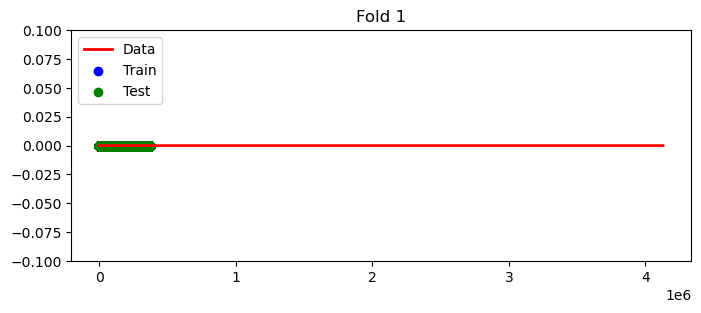

spatial cluster number 1
Clusters [0] being used here in training


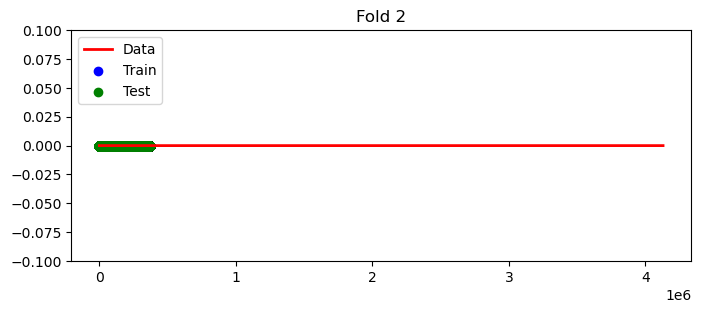

Temporal split number 1
spatial cluster number 0
Clusters [1] being used here in training


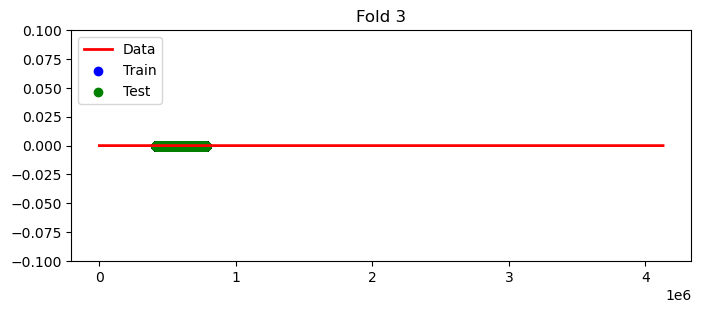

spatial cluster number 1
Clusters [0] being used here in training


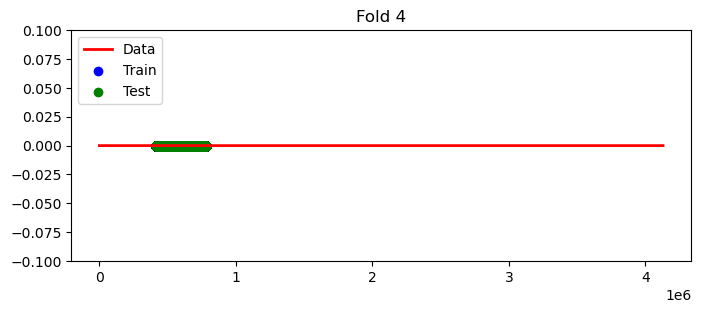

Temporal split number 1
spatial cluster number 0
Clusters [1] being used here in training


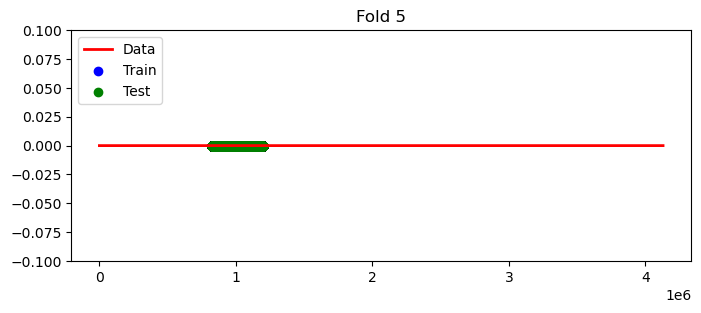

spatial cluster number 1
Clusters [0] being used here in training


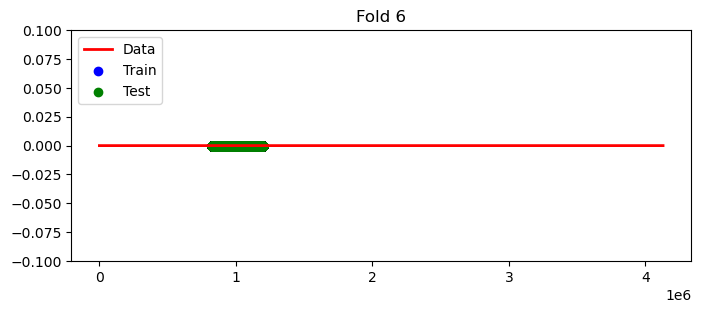

Temporal split number 1
spatial cluster number 0
Clusters [1] being used here in training


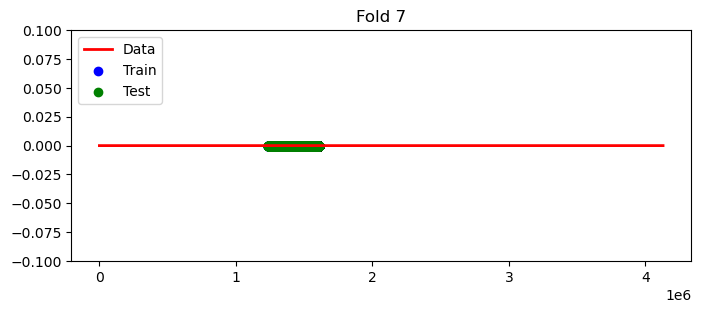

spatial cluster number 1
Clusters [0] being used here in training


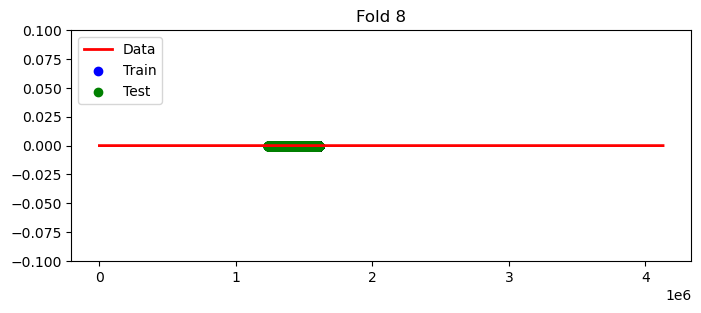

Temporal split number 1
spatial cluster number 0
Clusters [1] being used here in training


In [ ]:
data = Yfull
for fold, (train_index, test_index) in enumerate(btss.split(data)):
    # Plot the fold indices
    plt.figure(figsize=(8, 3))
    plt.plot(np.arange(len(data)), np.zeros_like(data), 'r-', lw=2, label='Data')
    plt.scatter(train_index, np.zeros_like(train_index), c='b', marker='o', label='Train')
    plt.scatter(test_index, np.zeros_like(test_index), c='g', marker='o', label='Test')
    plt.title(f'Fold {fold+1}')
    plt.legend(loc='upper left')
    plt.ylim(-0.1, 0.1)
    plt.show()

In [48]:
cv_parameters = BlockingTimeSeriesSplit(n_splits=10)
# cv_parameters =  KFold(n_splits=10, random_state=1, shuffle=True)
# cv_parameters = TimeSeriesSplit(n_splits=10)

In [63]:
# Create the BlockedTimeSeriesSplit object
btss = BlockingTimeSeriesSplit(n_splits=3)
# Perform cross-validation with spatial and temporal blocking
for train_temporal_index, test_temporal_index in btss.split(X):
    print(train_temporal_index, test_temporal_index)

[      0       1       2 ... 1238721 1238722 1238723] [1238724 1238725 1238726 ... 1376357 1376358 1376359]
[1376360 1376361 1376362 ... 2615081 2615082 2615083] [2615084 2615085 2615086 ... 2752717 2752718 2752719]
[2752720 2752721 2752722 ... 3991441 3991442 3991443] [3991444 3991445 3991446 ... 4129077 4129078 4129079]


In [65]:
# Dataframe to store the scores for all the models
#error_metric_scores = pd.DataFrame()

for model_name, model_pipeline in models_dict.items():
    print(model_name)
    # Use cross_validate to return the error scores associated with this model and this data
    start = time()
    model_output = cross_validate(model_pipeline, Xfull, Yfull, cv=cv_parameters, scoring=error_metrics, error_score="raise")
    end = time()
    print('Ran in {} minutes'.format(round((end - start)/60),2))
    
    # Formulate the different error scores into a dataframe
    error_metrics_df =pd.DataFrame({'mae': round(abs(model_output['test_neg_mean_absolute_error'].mean()),2), 
                  'mape': round(abs(model_output['test_neg_mean_absolute_percentage_error'].mean()),2),
                  'r2': round(abs(model_output['test_r2'].mean()),2), 
                  'rmse': round(abs(model_output['test_neg_root_mean_squared_error'].mean()),2)},
                 index =[model_name])
        
    # Add evaluation metric scores for this model to the dataframe containing the metrics for each model
    error_metric_scores = error_metric_scores.append(error_metrics_df)
    # Save error scores for this distance to file
    error_metrics_df.to_csv('Results/CV/ComparingModels/{}_{}m_error_metric_scores.csv'.format(model_name,buffer_size_m),index=False)    

# Save dataframes of error metrics for each buffer distance 
error_metric_scores.to_csv('Results/CV/ComparingModels/comparingmodels_error_metric_scores.csv')   

rf_regressor
Ran in 4 minutes


### Print table showing error metrics associated with each model

In [68]:
error_metric_scores

,mae,mape,r2,rmse
rf_regressor,100.29,2.631653e+15,0.75,199.69
rf_regressor,100.29,2.631653e+15,0.75,199.69
rf_regressor,100.29,2.631653e+15,0.75,199.69
rf_regressor,100.29,2.631653e+15,0.75,199.69
rf_regressor,58.35,1.438735e+15,0.94,120.87
rf_regressor,100.29,2.631653e+15,0.75,199.69
